### Cloning my Git Repo

In [1]:
!git clone https://github.com/Jawakar-7/Image-Classification-using-multiple-models-.git

Cloning into 'Image-Classification-using-multiple-models-'...
remote: Enumerating objects: 24345, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 24345 (delta 10), reused 13 (delta 4), pack-reused 24316
Receiving objects: 100% (24345/24345), 343.38 MiB | 18.75 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (24342/24342), done.


### Import the necessary files:

In [2]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
test_path='/content/Image-Classification-using-multiple-models-/Datasets/seg_test/seg_test'
train_path='/content/Image-Classification-using-multiple-models-/Datasets/seg_train/seg_train'

### Image data Generator
It is a library available in keras.preprocessing to extract images from class files and accordingly set class names for them (we need the images to be in a seperate class files for this function to work)
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

This is an effective way of accessing images instead of using the os package to parse through all the files one by one.

In [4]:
from sklearn.utils import column_or_1d
train_xgen=ImageDataGenerator(
    rescale=1.0/255,#Scaling Down the data
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.1,
)
X_train=train_xgen.flow_from_directory(
    train_path,
    target_size=(150,150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32
)

Found 14034 images belonging to 6 classes.


In [5]:
test_xgen=ImageDataGenerator(
    rescale=1.0/255
)
X_test=test_xgen.flow_from_directory(
    test_path,
    class_mode='categorical',
    target_size=(150,150),
    batch_size=32,
    color_mode='rgb',
    shuffle=True
)

Found 3000 images belonging to 6 classes.


The output of ImageDataGenerator is a Generator object.

In [6]:
labels={i:k for k,i in X_train.class_indices.items()}
for i,k in labels.items():
  print(f"{i}:{k}")

0:buildings
1:forest
2:glacier
3:mountain
4:sea
5:street


In [7]:
print(f"{len(X_train)} which is total images/32")

439 which is total images/32


In [8]:
for i,k in X_train:
  print(f"{i.shape}is a tuple that contains(batch size,target size and channel_size,) and k is the corresponding classes of 32 images {labels[np.argmax(k[0],axis=0)]} meaning the last class")
  break

(32, 150, 150, 3)is a tuple that contains(batch size,target size and channel_size,) and k is the corresponding classes of 32 images forest meaning the last class


 So we have 439 batches of images each contains 32 images in size 32, 150 ,150, 3 shape and their corresponding labels .

In [9]:
X_train[0][1][0]#accesing the label of first element from the first batch

array([0., 1., 0., 0., 0., 0.], dtype=float32)

### Now that we have all our images in seperate classes we will try to visualize them using matplotlib

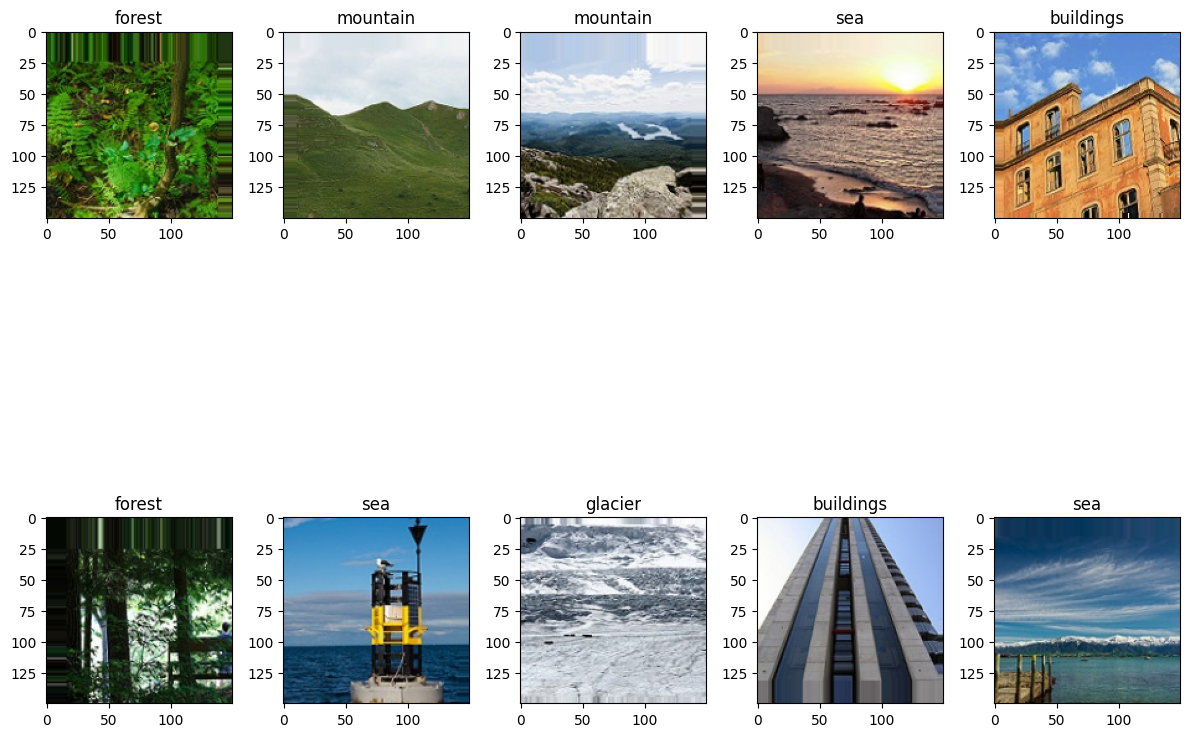

In [10]:
fig , ax=plt.subplots(ncols=5,nrows=2,figsize=(12,12))
t=0
for a in range(2):
    for  b in range(5):
      label=labels[np.argmax(X_train[0][1][t])]
      ax[a,b].set_title(label)
      ax[a,b].imshow(X_train[0][0][t][:,:,:])
      ax[a,b].axis='off'
      t+=1
plt.tight_layout()
plt.suptitle="Sample Training Images"
plt.show()



## Building a CNN Model
Padding:
https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480

####Strides:
By the way, does a filter always have to move one pixel at a time? Of course not. We can also make it move two steps or three steps at a time both in the horizontal and vertical ways. This is called ‘stride.’

Stride is a parameter that works in conjunction with padding, the feature that adds blank, or empty pixels to the frame of the image to allow for a minimized reduction of size in the output layer. Roughly, it is a way of increasing the size of an image, to counteract the fact that stride reduces the size. Padding and stride are the foundational parameters of any convolutional neural network.
Input:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
If you apply a filter with a size of 3 and a stride of 3, the filter would move as follows:

First position: [1, 2, 3] (covering indices 0, 1, and 2)
Second position: [4, 5, 6] (covering indices 3, 4, and 5)
Third position: [7, 8, 9] (covering indices 6, 7, and 8)

####Input Shape:
 4+D tensor with shape: batch_shape + (channels, rows, cols) if data_format='channels_first' or 4+D tensor with shape: batch_shape + (rows, cols, channels) if data_format='channels_last'.

####BatchNormalization Layer:
https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/
mainly to be added when we are dealing with multi class classification where images of same class can be of different colours.

add image


In [11]:
from keras.models import Sequential
from keras.layers import Activation , BatchNormalization , Dense , Dropout , Flatten , MaxPooling2D,Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from  keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam

In [12]:
def CreateCNN():

  model=Sequential([
      Conv2D(filters=128,kernel_size=(5,5),activation='relu',input_shape=(150,150,3),strides=(1, 1),padding='valid'),
      Conv2D(filters=64,kernel_size=(5,5),activation='relu'),
      MaxPooling2D((2,2)),
      BatchNormalization(),
      Dropout(rate=0.25),#makes 0.25 cent of the neurons to be numb in forward propogation to avoid overfitting
      Conv2D(filters=64,kernel_size=(5,5),activation='relu'),
      MaxPooling2D((2,2)),
      BatchNormalization(),
      Dropout(rate=0.10),
      Conv2D(filters=32,kernel_size=(5,5),activation='relu'),
      MaxPooling2D((2,2)),
      BatchNormalization(),
      Dropout(rate=0.10),

      Flatten(),#compress all the convo layers to one single layer
      Dense(units=256,activation='relu'),
      Dropout(0.5),
      Dense(units=6,activation='softmax')
  ])

  return model



In [13]:
cnn_mod=CreateCNN()

###Model Summary

In [14]:
print(cnn_mod.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 conv2d_1 (Conv2D)           (None, 142, 142, 64)      204864    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 71, 71, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 71, 71, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 67, 67, 64)        1

####Callbacks:
https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

https://keras.io/api/callbacks/


functions or objects that can be passed to training algorithms to customize and extend their behavior during the training process. Callbacks allow you to perform certain actions at specific points during training, such as after each epoch or batch. They are often used to monitor the model's performance, adjust hyperparameters, save model checkpoints, or implement custom logic.

The learning rate may be the most important hyperparameter when configuring your neural network. Therefore it is vital to know how to investigate the effects of the learning rate on model performance and to build an intuition about the dynamics of the learning rate on model behavior.

Keras provides the ReduceLROnPlateau that will adjust the learning rate when a plateau in model performance is detected, e.g. no change for a given number of training epochs. This callback is designed to reduce the learning rate after the model stops improving with the hope of fine-tuning model weights.

Keras also provides LearningRateScheduler callback that allows you to specify a function that is called each epoch in order to adjust the learning rate.

You can define your Python function that takes two arguments (epoch and current learning rate) and returns the new learning rate.

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

monitor: quantity to be monitored.

factor: factor by which the learning rate will be reduced. new_lr = lr * factor.

patience: number of epochs with no improvement after which learning rate will be reduced.

####Optimizers:
https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/#Adam_Deep_Learning_Optimizer

While training the deep learning optimizers model, modify each epoch’s weights and minimize the loss function. An optimizer is a function or an algorithm that adjusts the attributes of the neural network, such as weights and learning rates. Thus, it helps in reducing the overall loss and improving accuracy. The problem of choosing the right weights for the model is a daunting task, as a deep learning model generally consists of millions of parameters. It raises the need to choose a suitable optimization algorithm for your application.


In [16]:

optimizer = Adam(learning_rate=0.001)

####Compiling the model

In [17]:
cnn_mod.compile(optimizer=optimizer,loss=CategoricalCrossentropy(),metrics=['accuracy'])

In [18]:
history = cnn_mod.fit(X_train, epochs=50, validation_data=X_test,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
439/439 - 127s - loss: 2.0808 - accuracy: 0.4783 - val_loss: 1.3206 - val_accuracy: 0.5140 - lr: 0.0010 - 127s/epoch - 289ms/step
Epoch 2/50
439/439 - 111s - loss: 1.0983 - accuracy: 0.5911 - val_loss: 0.9097 - val_accuracy: 0.6563 - lr: 0.0010 - 111s/epoch - 252ms/step
Epoch 3/50
439/439 - 108s - loss: 0.9456 - accuracy: 0.6419 - val_loss: 0.9319 - val_accuracy: 0.6200 - lr: 0.0010 - 108s/epoch - 247ms/step
Epoch 4/50
439/439 - 106s - loss: 0.8829 - accuracy: 0.6746 - val_loss: 0.9537 - val_accuracy: 0.6740 - lr: 0.0010 - 106s/epoch - 242ms/step
Epoch 5/50
439/439 - 106s - loss: 0.8127 - accuracy: 0.7054 - val_loss: 0.8351 - val_accuracy: 0.7027 - lr: 0.0010 - 106s/epoch - 242ms/step
Epoch 6/50
439/439 - 104s - loss: 0.7753 - accuracy: 0.7179 - val_loss: 0.7654 - val_accuracy: 0.7230 - lr: 0.0010 - 104s/epoch - 237ms/step
Epoch 7/50
439/439 - 105s - loss: 0.7184 - accuracy: 0.7366 - val_loss: 0.6020 - val_accuracy: 0.7927 - lr: 0.0010 - 105s/epoch - 240ms/step
Epoch 8/50
43

In [20]:
history.save('my_model.keras')

AttributeError: ignored